In [1]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import plotters as pt
import os 
import pickle
import numpy as np
import transformers as tf



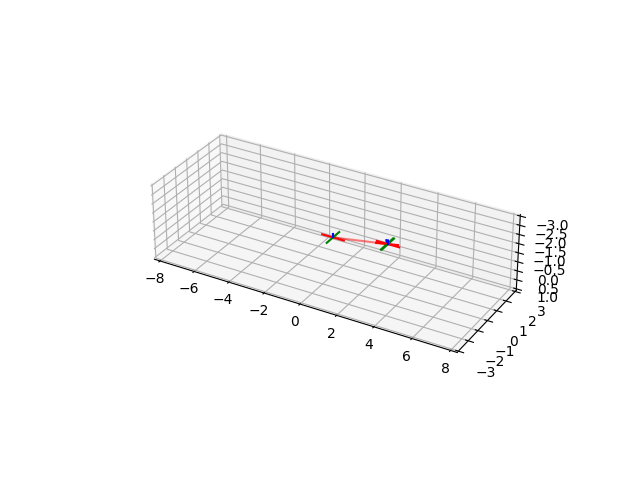

In [3]:
data_path = os.path.join("data","ascend"+".pkl")

# Load Flight Data
with open(data_path,'rb') as file:
    idl_data = pickle.load(file)

Ti:np.ndarray   = idl_data['Ti']
FOi:np.ndarray  = idl_data['FOi']
tXUi:np.ndarray = idl_data['tXUi']
Ci:np.ndarray   = idl_data['Ci']

pt.tXU_to_3D([tXUi])

In [4]:
print("Ti (first 5 entries):", Ti[:5])
print("FOi (first 5 entries):", FOi[:5])
print("tXUi (first 5 entries):", tXUi[:5])
print("Ci (first 5 entries):", Ci[:5])


Ti (first 5 entries): [0.    0.005 0.01  0.015 0.02 ]
FOi (first 5 entries): [[[-7.85304432e-08 -1.10725772e-07 -3.37095344e-08 -1.50306686e-07
    3.10459506e+01 -1.23494508e+02  2.00253226e+02 -1.03822200e+02
   -1.11992149e+02  2.42301746e+02 -3.19639958e+02  1.96666868e+02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [-9.99691994e-01  2.87610334e-08  3.06035762e-09  1.52245551e-08
   -5.17432508e+00  2.05824180e+01 -3.33755376e+01  1.73037003e+01
    1.86653572e+01 -4.03836226e+01  5.32733241e+01 -3.27778099e+01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[-7.82792199e-08  5.32683648e-07  3.85472331e-04  1.53690091e-01
    3.04309791e+01 -1.22494542e+02  1.99732720

In [5]:
# Extract x position data from FOi
x_positions_FOi = FOi[:, 0, 0]

# Prepare dataset for supervised learning
X_FOi = x_positions_FOi#[:-1]  # Current x positions
y_FOi = x_positions_FOi#[1:]   # Next x positions

# Manually split the dataset into training, validation, and test sets
# Shuffle the dataset indices
indices_FOi = np.arange(X_FOi.shape[0])
np.random.shuffle(indices_FOi)

# Determine split sizes based on the corrected dataset size
train_size_FOi = int(0.8 * len(indices_FOi))  # 80% for training
val_size_FOi = int(0.1 * len(indices_FOi))    # 10% for validation
test_size_FOi = len(indices_FOi) - train_size_FOi - val_size_FOi  # The remaining 10% for testing

# Split the dataset indices
train_indices_FOi = indices_FOi[:train_size_FOi]
val_indices_FOi = indices_FOi[train_size_FOi:train_size_FOi + val_size_FOi]
test_indices_FOi = indices_FOi[train_size_FOi + val_size_FOi:]

# Extract the dataset splits using the indices
X_train_FOi = X_FOi[train_indices_FOi]
y_train_FOi = y_FOi[train_indices_FOi]

X_val_FOi = X_FOi[val_indices_FOi]
y_val_FOi = y_FOi[val_indices_FOi]

X_test_FOi = X_FOi[test_indices_FOi]
y_test_FOi = y_FOi[test_indices_FOi]

# Output the shapes of the splits to confirm the process
X_train_FOi.shape, X_val_FOi.shape, X_test_FOi.shape,y_train_FOi.shape, y_val_FOi.shape, y_test_FOi.shape

((480,), (60,), (61,), (480,), (60,), (61,))

In [6]:
print("Min value in X_train_FOi:", np.min(x_positions_FOi))
print("Max value in X_train_FOi:", np.max(x_positions_FOi))
print(x_positions_FOi)


Min value in X_train_FOi: -7.853044322293487e-08
Max value in X_train_FOi: 2.9991701989815738
[-7.85304432e-08 -7.82792199e-08 -6.68062329e-08 -1.54859788e-08
  1.22945690e-07  4.14013440e-07  9.41127437e-07  1.80521142e-06
  3.12433386e-06  5.03334223e-06  7.68350026e-06  1.12421284e-05
  1.58922471e-05  2.18322236e-05  2.92754209e-05  3.84498510e-05
  4.95978298e-05  6.29756362e-05  7.88531733e-05  9.75136331e-05
  1.19253164e-04  1.44380542e-04  1.73216843e-04  2.06095120e-04
  2.43360081e-04  2.85367776e-04  3.32485277e-04  3.85090367e-04
  4.43571234e-04  5.08326164e-04  5.79763234e-04  6.58300020e-04
  7.44363289e-04  8.38388716e-04  9.40820582e-04  1.05211149e-03
  1.17272209e-03  1.30312076e-03  1.44378339e-03  1.59519301e-03
  1.75783963e-03  1.93221988e-03  2.11883675e-03  2.31819938e-03
  2.53082274e-03  2.75722740e-03  2.99793925e-03  3.25348926e-03
  3.52441322e-03  3.81125150e-03  4.11454880e-03  4.43485389e-03
  4.77271939e-03  5.12870151e-03  5.50335983e-03  5.89725707e

In [7]:
import numpy as np

def normalize_data(data, feature_range=(0, 1)):
    """
    Normalize data to a specified range.

    Parameters:
    - data: Data to be normalized (numpy array).
    - feature_range: Tuple (min, max) specifying the range of the normalized data.

    Returns:
    - normalized_data: Normalized data.
    """
    min_val, max_val = feature_range
    data_min = np.min(data)
    data_max = np.max(data)
    # Scale data to [0,1]
    normalized_data = (data - data_min) / (data_max - data_min)
    # Scale data to feature_range
    normalized_data = normalized_data * (max_val - min_val) + min_val
    return normalized_data

# Assuming X_data and Y_data are your data arrays
# Normalize X_data and Y_data

# Use distinct token values


# Then proceed with your segmentation or other processing steps


In [8]:
import numpy as np

Xtr_data_normalized = normalize_data(np.array(X_train_FOi))
Ytr_data_normalized = normalize_data(np.array(y_train_FOi))
Xv_data_normalized = normalize_data(np.array(X_val_FOi))
Yv_data_normalized = normalize_data(np.array(y_val_FOi))
Xte_data_normalized = normalize_data(np.array(X_test_FOi))
Yte_data_normalized = normalize_data(np.array(y_test_FOi))

# # Scale to an integer range, e.g., [0, 10000]
# xtrint_data = np.round(Xtr_data_normalized * 10000).astype(np.int64)
# ytrint_data = np.round(Ytr_data_normalized * 10000).astype(np.int64)
# xvint_data = np.round(Xv_data_normalized * 10000).astype(np.int64)
# yvint_data = np.round(Yv_data_normalized * 10000).astype(np.int64)
# xteint_data = np.round(Xte_data_normalized * 10000).astype(np.int64)
# yteint_data = np.round(Yte_data_normalized * 10000).astype(np.int64)

# Choose SOS and EOS tokens
SOS_token = 10001  # Start of sequence token
EOS_token = 10002  # End of sequence token


In [9]:
import numpy as np

def segment_data(X, Y, length=8, SOS_token=10001, EOS_token=10002):
    """
    Segments the given X and Y arrays into sequences of the specified length,
    including SOS and EOS tokens at the beginning and end of each sequence.
    Each sequence overlaps with the next, where the last element of one sequence
    is the first element of the next.

    Parameters:
    - X: Input data array
    - Y: Target data array
    - length: The length of each segmented sequence (default: 8)
    - SOS_token: Start of sequence token (default: -1) -this token should change it's value it could mess data
    - EOS_token: End of sequence token (default: 10001) -this token should change it's value it could mess data

    Returns:
    - A list of segmented data pairs [segmented_X, segmented_Y] with SOS and EOS tokens
    """
    data = []
    X = np.array(X)
    Y = np.array(Y)

    for i in range(len(X) - length + 1):
        X_segment = X[i:i + length]
        Y_segment = Y[i:i + length]
        
        # Print original segments before adding tokens
        print(f'Original X_segment[{i}]: {X_segment}')
        print(f'Original Y_segment[{i}]: {Y_segment}')
        
        # Insert SOS at the beginning and EOS at the end of each segment
        X_segment = np.insert(X_segment, 0, SOS_token)
        Y_segment = np.insert(Y_segment, 0, SOS_token)
        X_segment = np.append(X_segment, EOS_token)
        Y_segment = np.append(Y_segment, EOS_token)
        
        # Print segments after adding tokens
        print(f'With Tokens X_segment[{i}]: {X_segment}')
        print(f'With Tokens Y_segment[{i}]: {Y_segment}')

        data.append([X_segment, Y_segment])

    np.random.shuffle(data)
    return data

# Example usage with your data:
X_data = X_train_FOi  # Your X_train data here
Y_data = y_train_FOi # Your Y_train data here

train_segmented_data = segment_data(X_data, Y_data, length=8)
for pair in train_segmented_data[:5]:  # Print the first 5 pairs to check
    print(f'X: {pair[0]}, Y: {pair[1]}')


Original X_segment[0]: [2.96002045e+00 4.95978298e-05 2.88116530e+00 1.84577736e+00
 4.04444962e-01 2.99745934e+00 2.99895153e+00 1.02876244e-01]
Original Y_segment[0]: [2.96002045e+00 4.95978298e-05 2.88116530e+00 1.84577736e+00
 4.04444962e-01 2.99745934e+00 2.99895153e+00 1.02876244e-01]
With Tokens X_segment[0]: [1.00010000e+04 2.96002045e+00 4.95978298e-05 2.88116530e+00
 1.84577736e+00 4.04444962e-01 2.99745934e+00 2.99895153e+00
 1.02876244e-01 1.00020000e+04]
With Tokens Y_segment[0]: [1.00010000e+04 2.96002045e+00 4.95978298e-05 2.88116530e+00
 1.84577736e+00 4.04444962e-01 2.99745934e+00 2.99895153e+00
 1.02876244e-01 1.00020000e+04]
Original X_segment[1]: [4.95978298e-05 2.88116530e+00 1.84577736e+00 4.04444962e-01
 2.99745934e+00 2.99895153e+00 1.02876244e-01 6.49853900e-01]
Original Y_segment[1]: [4.95978298e-05 2.88116530e+00 1.84577736e+00 4.04444962e-01
 2.99745934e+00 2.99895153e+00 1.02876244e-01 6.49853900e-01]
With Tokens X_segment[1]: [1.00010000e+04 4.95978298e-05

In [10]:
# import numpy as np

# def segment_data(X, Y, length=8):
#     """
#     Segments the given X and Y arrays into sequences of the specified length.
#     Each sequence overlaps with the next, where the last element of one sequence
#     is the first element of the next.

#     Parameters:
#     - X: Input data array
#     - Y: Target data array
#     - length: The length of each segmented sequence (default: 8)

#     Returns:
#     - A list of segmented data pairs [segmented_X, segmented_Y]
#     """
#     data = []
    
#     # Ensure X and Y are numpy arrays for consistency in processing
#     X = np.array(X)
#     Y = np.array(Y)

#     # Segment the data
#     num_segments = len(X) - length + 1  # Calculate the number of segments
#     for i in range(num_segments):
#         X_segment = X[i:i + length]
#         Y_segment = Y[i:i + length]
#         data.append([X_segment, Y_segment])

#     # Optionally, shuffle the segmented data pairs to randomize the order
#     np.random.shuffle(data)

#     return data

# # Example usage:
# X_data = X_train_FOi
# Y_data = y_train_FOi

# train_segmented_data = segment_data(X_data, Y_data, length=8)
# for pair in train_segmented_data:
#     print(f'X: {pair[0]}, Y: {pair[1]}')


In [11]:
val_segmented_data = segment_data(X_val_FOi, y_val_FOi, length=8)

Original X_segment[0]: [9.41127437e-07 6.49396033e-02 2.01145796e+00 1.74984265e+00
 1.61993083e+00 1.60619915e-01 5.58917416e-01 2.91037101e+00]
Original Y_segment[0]: [9.41127437e-07 6.49396033e-02 2.01145796e+00 1.74984265e+00
 1.61993083e+00 1.60619915e-01 5.58917416e-01 2.91037101e+00]
With Tokens X_segment[0]: [1.00010000e+04 9.41127437e-07 6.49396033e-02 2.01145796e+00
 1.74984265e+00 1.61993083e+00 1.60619915e-01 5.58917416e-01
 2.91037101e+00 1.00020000e+04]
With Tokens Y_segment[0]: [1.00010000e+04 9.41127437e-07 6.49396033e-02 2.01145796e+00
 1.74984265e+00 1.61993083e+00 1.60619915e-01 5.58917416e-01
 2.91037101e+00 1.00020000e+04]
Original X_segment[1]: [0.0649396  2.01145796 1.74984265 1.61993083 0.16061992 0.55891742
 2.91037101 0.04081504]
Original Y_segment[1]: [0.0649396  2.01145796 1.74984265 1.61993083 0.16061992 0.55891742
 2.91037101 0.04081504]
With Tokens X_segment[1]: [1.00010000e+04 6.49396033e-02 2.01145796e+00 1.74984265e+00
 1.61993083e+00 1.60619915e-01 5.

In [12]:
test_segmented_data = segment_data(X_test_FOi, y_test_FOi, length=8)

Original X_segment[0]: [0.30470965 0.00325349 2.69468754 2.7877642  1.53260549 1.79267639
 2.97963323 0.0187002 ]
Original Y_segment[0]: [0.30470965 0.00325349 2.69468754 2.7877642  1.53260549 1.79267639
 2.97963323 0.0187002 ]
With Tokens X_segment[0]: [1.00010000e+04 3.04709653e-01 3.25348926e-03 2.69468754e+00
 2.78776420e+00 1.53260549e+00 1.79267639e+00 2.97963323e+00
 1.87002048e-02 1.00020000e+04]
With Tokens Y_segment[0]: [1.00010000e+04 3.04709653e-01 3.25348926e-03 2.69468754e+00
 2.78776420e+00 1.53260549e+00 1.79267639e+00 2.97963323e+00
 1.87002048e-02 1.00020000e+04]
Original X_segment[1]: [0.00325349 2.69468754 2.7877642  1.53260549 1.79267639 2.97963323
 0.0187002  2.83872538]
Original Y_segment[1]: [0.00325349 2.69468754 2.7877642  1.53260549 1.79267639 2.97963323
 0.0187002  2.83872538]
With Tokens X_segment[1]: [1.00010000e+04 3.25348926e-03 2.69468754e+00 2.78776420e+00
 1.53260549e+00 1.79267639e+00 2.97963323e+00 1.87002048e-02
 2.83872538e+00 1.00020000e+04]
With

In [13]:
import numpy as np

def batchify_data(data, batch_size=16, padding=False, padding_token=10003):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_batch_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


In [14]:
#set the batchify 
train_dataloader = batchify_data(train_segmented_data, batch_size=16, padding=True)
val_dataloader = batchify_data(val_segmented_data, batch_size=16, padding=True)
test_dataloader = batchify_data(test_segmented_data, batch_size=16, padding=True)

29 batches of size 16
3 batches of size 16
3 batches of size 16


In [15]:
print(f"Train batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

# If batches are not empty, check the shape of the first batch
if train_dataloader:
    print(f"First train batch shape: {train_dataloader[0].shape}")
if val_dataloader:
    print(f"First validation batch shape: {val_dataloader[0].shape}")
if test_dataloader:
    print(f"First test batch shape: {test_dataloader[0].shape}")


Train batches: 29
Validation batches: 3
Test batches: 3
First train batch shape: (16, 2, 10)
First validation batch shape: (16, 2, 10)
First test batch shape: (16, 2, 10)


In [16]:
import torch

In [17]:
model = tf.Transformer(
    num_tokens=10003, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
)
# model = tf.Transformer(
#     input_dim=1,dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
# )

/home/aditipat/anaconda3/envs/sfti-env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
train_loss_list, validation_loss_list = tf.fit(model, train_dataloader, val_dataloader, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
Prediction: tensor([[[-1.2911e-01, -2.0602e-01,  1.9232e-01,  ..., -7.3661e-02,
          -5.5330e-01, -4.1208e-01],
         [-4.9141e-01, -5.2410e-01,  2.2912e-01,  ..., -4.1249e-01,
          -6.4952e-01, -8.2868e-01],
         [-3.8416e-01,  6.1320e-01,  1.8717e-01,  ...,  6.1833e-01,
           6.8928e-01,  8.7464e-01],
         ...,
         [ 1.7714e-01, -4.6384e-01,  1.0045e+00,  ...,  6.9522e-01,
           7.3428e-01,  1.2988e-01],
         [ 1.7976e-01,  4.8987e-01, -1.1641e+00,  ..., -1.0391e+00,
          -4.8267e-01, -1.2212e-01],
         [ 9.0436e-01, -6.0591e-01, -6.5464e-01,  ..., -1.2038e+00,
          -1.3795e+00, -1.1976e+00]],

        [[-3.8969e-01,  2.3068e-01,  3.1647e-02,  ..., -4.1290e-01,
          -1.9318e-01, -1.2343e-01],
         [-5.2568e-01, -8.5539e-02, -5.7584e-02,  ..., -1.7418e-01,
          -3.4082e-01, -5.6187e-01],
         [-4.8627e-01, -3.1260e-01, -1.598

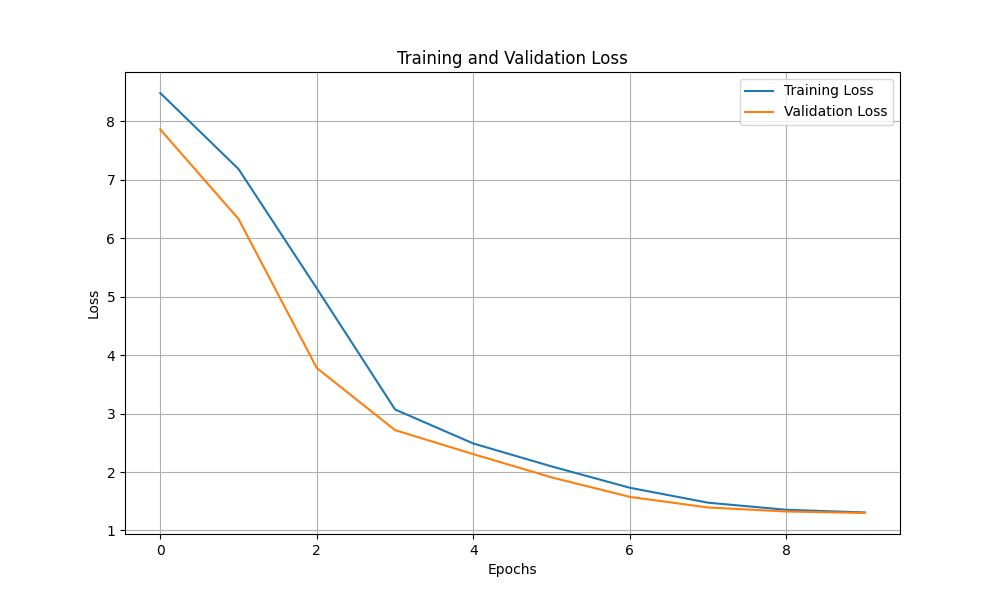

In [19]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import torch
# Fetch one batch from the test_dataloader
for batch in test_dataloader:
    print(f"Batch structure: {type(batch)}")
    if isinstance(batch, (list, tuple)):
        print(f"Number of elements in the batch: {len(batch)}")
    # Optionally, print the shapes or types of the first few elements to understand their structure
    for i, item in enumerate(batch):
        if torch.is_tensor(item):
            print(f"Element {i} shape: {item.shape}")
        else:
            print(f"Element {i} is a {type(item)}")
    break  # Only inspect the first batch


Batch structure: <class 'numpy.ndarray'>
Element 0 is a <class 'numpy.ndarray'>
Element 1 is a <class 'numpy.ndarray'>
Element 2 is a <class 'numpy.ndarray'>
Element 3 is a <class 'numpy.ndarray'>
Element 4 is a <class 'numpy.ndarray'>
Element 5 is a <class 'numpy.ndarray'>
Element 6 is a <class 'numpy.ndarray'>
Element 7 is a <class 'numpy.ndarray'>
Element 8 is a <class 'numpy.ndarray'>
Element 9 is a <class 'numpy.ndarray'>
Element 10 is a <class 'numpy.ndarray'>
Element 11 is a <class 'numpy.ndarray'>
Element 12 is a <class 'numpy.ndarray'>
Element 13 is a <class 'numpy.ndarray'>
Element 14 is a <class 'numpy.ndarray'>
Element 15 is a <class 'numpy.ndarray'>


In [21]:
def unnormalize_data(normalized_data, original_min, original_max, feature_range=(0, 1)):
    """
    Unnormalize data back to its original scale.
    
    Parameters:
    - normalized_data: The data to be unnormalized.
    - original_min: The minimum value of the original data before normalization.
    - original_max: The maximum value of the original data before normalization.
    - feature_range: The range to which the data was normalized.
    
    Returns:
    - unnormalized_data: Data converted back to its original scale.
    """
    min_val, max_val = feature_range
    # Reverse the scaling
    scaled_data = (normalized_data - min_val) / (max_val - min_val)
    # Reverse the normalization
    unnormalized_data = scaled_data * (original_max - original_min) + original_min
    return unnormalized_data


In [26]:
import sys
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
import torch

def predict(model, input_sequence, max_length=15, SOS_token=10001, EOS_token=10002):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)
    continuation = []

    for _ in range(max_length):
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1][:, -1, :].squeeze().detach()
        continuation.append(next_item.item())
        
        y_input = torch.cat((y_input, next_item.unsqueeze(0).unsqueeze(0)), dim=1)
        
        if next_item.item() == EOS_token:
            break

    return continuation

# Test the predict function with your examples
examples = [
    torch.tensor([[10001, 0, 9996, 9295, 6189, 333, 10000, 2026, 8907, 10002]], dtype=torch.long, device=device),
]

for idx, example in enumerate(examples):
    result = predict(model, example, SOS_token=10001, EOS_token=10002)
    print(f"Example {idx}")
    print(f"Input: {example[0, 1:-1].tolist()}")  # Exclude SOS and EOS tokens for the input display
    print(f"Continuation: {result[:-1]}")  # Exclude the EOS token from the continuation display
    print()


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar